In [80]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from operator import truediv
from tokenize import group
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import statsmodels.api as sm
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from copy import copy

def lstsq(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    coefs, *rest = np.linalg.lstsq(A, y, rcond=None)
    return coefs
def pred(g, params):
    a, b = params
    return 10**(b) * g**a

def binned_line_fit(X, Y, nbins=5, eps=0.1, return_bins=False):
    hist, bins = np.histogram(X, range=(X.min(), X.max()+eps), bins=nbins)
    X_bins = np.digitize(X, bins)
    X_new = np.zeros(nbins)
    Y_new = np.zeros(nbins)
    mask = np.ones(len(X_new)).astype(bool)
    assert X_bins.max() == nbins
    for i in range(nbins):
        center = (bins[i] + bins[i+1]) /2
        ymin = Y[X_bins==i+1].min()
        if np.isnan(ymin):
            mask[i] = False
        X_new[i] = center
        Y_new[i] = ymin  
    X_new = X_new[mask]
    Y_new = Y_new[mask]
    if return_bins:
        return lstsq(X_new, Y_new), bins
    else:
        return lstsq(X_new, Y_new)

plt.rcParams.update({'font.size': 15})
upstream_colors = {
    "LAION-80M": "blue",
    "LAION-400M": "orange",
    "LAION-2B": "green",
    "CLIP-WIT": "black",
}
upstream_colors2 = {
    "LAION-80M": "orange",
    "LAION-400M": "orange",
    "LAION-2B": "orange",
    "CLIP-WIT": "blue",
}
upstream_dataset_styles = {
    "LAION-80M": "v",
    "LAION-400M": "o",
    "LAION-2B": "s",
    "CLIP-WIT": "*",

}
upstream_order = ["LAION-80M", "LAION-400M", "LAION-2B"]
samples_seen_sizes = {
    "3B": 100,
    "13B": 150,
    "34B": 300,
}
samples_seen_order = ["3B", "13B", "34B"]
arch_order = ["ViT-B/32", "ViT-B/16", "ViT-L/14", "ViT-H/14", "ViT-g/14"]
arch_sizes = {
    "ViT-B/32": 40, 
    "ViT-B/16": 80, 
    "ViT-L/14": 120,
    "ViT-H/14": 160, 
    "ViT-g/14": 200,
}
model_styles = {
    "ViT-B/32": "v", 
    "ViT-B/16": "o", 
    "ViT-L/14": "s",
    "ViT-H/14": "P", 
    "ViT-g/14": "*",

}
upstream_sizes = {
    "LAION-80M": 60,
    "LAION-400M": 100,
    "LAION-2B": 180,
    "CLIP-WIT": 100,
}
target_pretty = {
    "imagenet1k": "ImageNet",
    "mscoco_captions": "MS-COCO",
    "vtab+": "VTAB+",
    "vtab": "VTAB",
    "imagenet_robustness": "ImageNet robustness",
    "flickr30k": "Flickr30K",
}
default_acc_metric = defaultdict(lambda: 'acc1')
default_acc_metric.update({
    'mscoco_captions': 'image_retrieval_recall@5',
    'flickr30k': 'image_retrieval_recall@5',
    'flickr8k': 'image_retrieval_recall@5',
})
default_err_metric = defaultdict(lambda: 'err1')
default_err_metric.update({
    'mscoco_captions': 'image_retrieval_1minusrecall@5',
    'flickr30k': 'image_retrieval_1minusrecall@5',
    'flickr8k': 'image_retrieval_1minusrecall@5',
})
metric_pretty = {
    'acc1%': 'Top-1 accuracy %',
    'err1%': 'Error rate %',
    "image_retrieval_recall@5%": 'Image retrieval Recall@5',
    "text_retrieval_recall@5%": 'Text retrieval Recall@5',
    "image_retrieval_1minusrecall@5%": '(100 - Recall@5%)',
    "text_retrieval_1minusrecall@5%": '(100 - Recall@5%)'
}
metric_higher_is_better ={
    "image_retrieval_recall@5%": True,
    "text_retrieval_recall@5%": True,
    "acc1%": True,
    "err1%": False,
}
data_scale = {
    'LAION-80M': 80e6,
    'LAION-400M': 400e6,
    'LAION-2B': 2e9,
    'CLIP-WIT': 400e6,
}
task_metric  = {
    "imagenet": "err1%",
    "image_retrieval": 'image_retrieval_1minusrecall@5%',
    "text_retrieval": 'text_retrieval_1minusrecall@5%',
}

In [81]:
df = pd.read_csv("zeroshot_results.csv")
df['data_scale'] = df.upstream_dataset.apply(lambda d:data_scale[d])
df['image_retrieval_recall@5%'] = df['image_retrieval_recall@5'] * 100.0
df['text_retrieval_recall@5%'] = df['text_retrieval_recall@5'] * 100.0
df['image_retrieval_1minusrecall@5'] = 1 - df['image_retrieval_recall@5']
df['text_retrieval_1minusrecall@5'] =1 - df['image_retrieval_recall@5']
df['image_retrieval_1minusrecall@5%'] = 100*(1 - df['image_retrieval_recall@5'])
df['text_retrieval_1minusrecall@5%'] = 100*(1 - df['image_retrieval_recall@5'])
df['err1'] = df.apply(lambda row: (1-row[default_acc_metric[row.downstream_dataset]]), axis=1)
df['acc1%'] = df['acc1'] * 100.0
df['err1%'] = df['err1'] * 100.0
df['Model'] = df.arch.apply(lambda a:'-'.join(a.split('-')[0:-1]) + '/' + a.split('-')[-1])
df['Dataset'] = df['upstream_dataset']
df['Samples seen'] = df['samples_seen_pretty']
df['Dataset source'] = df.upstream_dataset.apply(lambda u:"CLIP-WIT" if u == "CLIP-WIT" else "LAION")

# Zero-Shot Scaling figures

/p/software/jurecadc/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/p/software/jurecadc/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


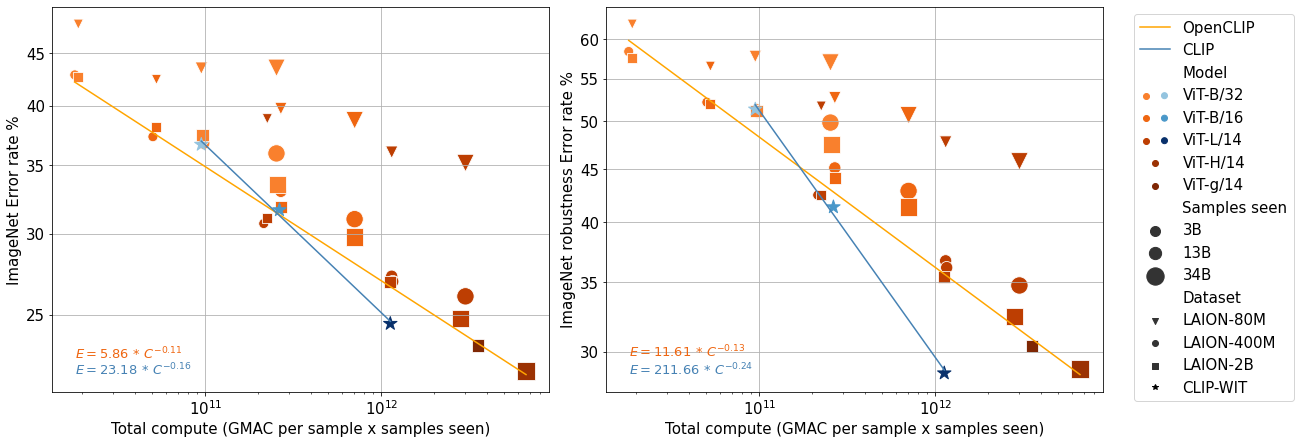

/p/software/jurecadc/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/p/software/jurecadc/stages/2022/software/Seaborn/0.11.2-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


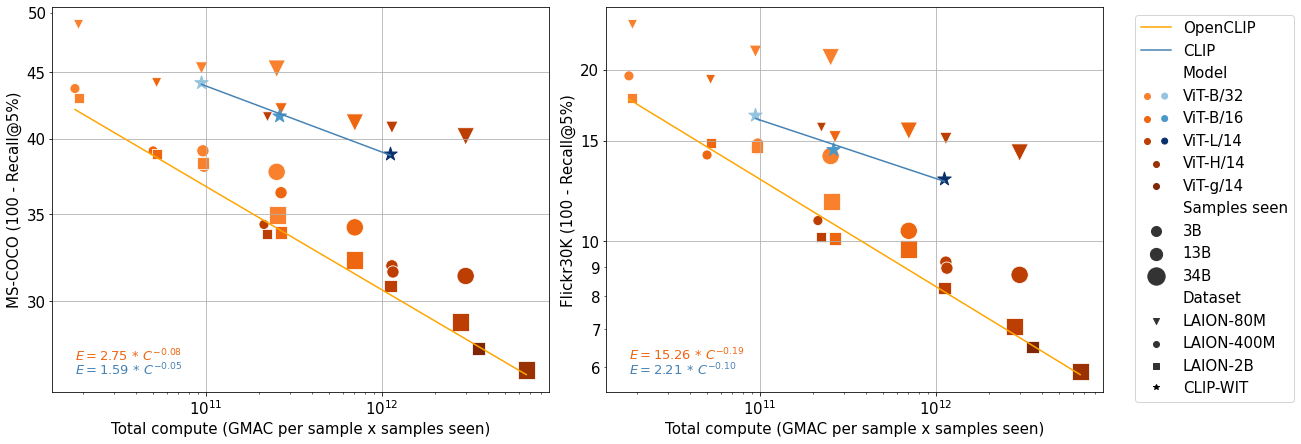

In [82]:
figsize = (18,6)
task_targets = {
    "imagenet": ('imagenet1k', 'imagenet_robustness'),
    "image_retrieval": ('mscoco_captions', 'flickr30k'),
    "text_retrieval": ('mscoco_captions', 'flickr30k'),

}
for task in ("imagenet", "image_retrieval"):
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=figsize)
    porange = cm.get_cmap('Oranges', 12)
    new_porange = porange(np.linspace(0.5, 1, len(arch_order) ))#
    names = task_targets[task]
    metric = task_metric[task]
    def get_formula_text(coefs):
        return f"$E = {10**(coefs[1]):.2f} \/*\/ C^{{ {coefs[0]:.2f} }}$"
    for ax, tgt in zip(axes, names):
        d = df[df.downstream_dataset==tgt]
        d = d.sort_values(by='gmacs_total')
        d_openclip = d[d.upstream_dataset != "CLIP-WIT"]
        d_openai = d[d.upstream_dataset == "CLIP-WIT"]
        X = np.log10(d_openclip.gmacs_total)
        Y = np.log10(d_openclip.err1)
        line_fit_loglog_openclip = binned_line_fit(X, Y, nbins=5)    
        line_fit_loglog_openai = lstsq(np.log10(d_openai.gmacs_total), np.log10(d_openai.err1))
        d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
        d = d.sort_values(by=["Dataset source", "data_scale"])
        sns.scatterplot(
            data=d_openclip.sort_values(by="data_scale"),
            x='gmacs_total',
            y='err1%',
            hue="Model",
            palette=new_porange,
            hue_order=arch_order,
            size="Samples seen",
            size_order=samples_seen_order,
            sizes=samples_seen_sizes,
            style='Dataset',
            markers=upstream_dataset_styles,
            ax=ax,
            s=120,
        )
        # OpenCLIP line
        x = d_openclip.gmacs_total.values
        y = (100* pred(d_openclip.gmacs_total, line_fit_loglog_openclip)).values
        ax.plot(x, y, color='orange', label='OpenCLIP')#, linestyle='dashed')
        xm = x.min()
        ym = y.min()
        shift = abs(y[-1] - y[-2]) * 0.5
        ax.annotate(get_formula_text(line_fit_loglog_openclip), xy=(xm, ym+shift), rotation=0, fontsize=13, color=new_porange[1])
        # OpenAI line
        x = d_openai.gmacs_total.values
        y = 100*pred(d_openai.gmacs_total, line_fit_loglog_openai).values
        ax.plot(x, y, color='steelblue', ms=10, label="CLIP")
        openai_cols = cm.get_cmap('Blues')
        openai_cols = [openai_cols(0.4), openai_cols(0.6), openai_cols(1.0)]
        ax.scatter(d_openai.gmacs_total.values, d_openai['err1%'].values, marker='*', s=200, c=openai_cols)
        ax.annotate(get_formula_text(line_fit_loglog_openai), xy=(xm, ym),rotation=0, fontsize=13, color='steelblue')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
        ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax.set_xlabel("Total compute (GMAC per sample x samples seen)")
        ax.set_ylabel(f"{target_pretty.get(tgt, tgt)} {metric_pretty[metric]}")
        minv = d_openclip['err1%'].min()
        maxv = d_openclip['err1%'].max()
        unit = 5
        minv = unit * (minv // unit + 1)
        maxv = unit * (maxv // unit + 1)
        ax.grid(True,)
        ax.set_yticks( np.arange(minv, maxv, unit) )
        if ax == axes[1]:
            from matplotlib.lines import Line2D
            ax.legend(bbox_to_anchor=(1.4,1))
            handles, labels = ax.get_legend_handles_labels()
            start = 3
            end = 6
            for i in range(start, end):
                hnew = copy(handles[i])
                hnew.set_facecolors([openai_cols[i-start], "none"])
                hnew.set_edgecolors([openai_cols[i-start], "none"])
                handles[i] = (handles[i], hnew)
            hnew = Line2D([0], [0], marker='*', c='black', linestyle='')
            handles.append(hnew)
            labels.append("CLIP-WIT")
            l = ax.legend(bbox_to_anchor=(1.4,1), labels=labels, handles=handles, handler_map={tuple: HandlerTuple(None)})
        else:
            ax.legend().set_visible(False)
    if task == "imagenet":
        plt.savefig(f"gmacs_vs_perf_imagenet_and_robustness.pdf")
    elif task == "image_retrieval":
        plt.savefig(f"gmacs_vs_perf_image_retrieval.pdf")
    elif task == "text_retrieval":
        plt.savefig(f"gmacs_vs_perf_text_retrieval.pdf")
    plt.show()

# Zero-shot prediction plot

Predictions based on log-log error model:
B-32 1B 53.39 actual:
B-32 3B 58.03 actual:57.358
B-32 13B 64.99 actual:63.227999999999994
B-32 34B 68.56 actual:66.474
B-32 68B 70.89 actual:
B-16 1B 58.41 actual:
B-16 3B 62.55 actual:62.684
B-16 13B 68.76 actual:68.134
B-16 34B 71.94 actual:70.222
B-16 68B 74.03 actual:
L-14 1B 64.62 actual:
L-14 3B 68.13 actual:69.306
L-14 13B 73.42 actual:73.096
L-14 34B 76.13 actual:75.202
L-14 68B 77.90 actual:
H-14 1B 67.55 actual:
H-14 3B 70.78 actual:
H-14 13B 75.62 actual:
H-14 34B 78.11 actual:77.972
H-14 68B 79.73 actual:
g-14 1B 69.04 actual:
g-14 3B 72.11 actual:
g-14 13B 76.74 actual:76.664
g-14 34B 79.11 actual:
g-14 68B 80.66 actual:
G-14 1B 71.06 actual:
G-14 3B 73.93 actual:
G-14 13B 78.26 actual:
G-14 34B 80.47 actual:
G-14 68B 81.92 actual:


<Figure size 432x288 with 0 Axes>

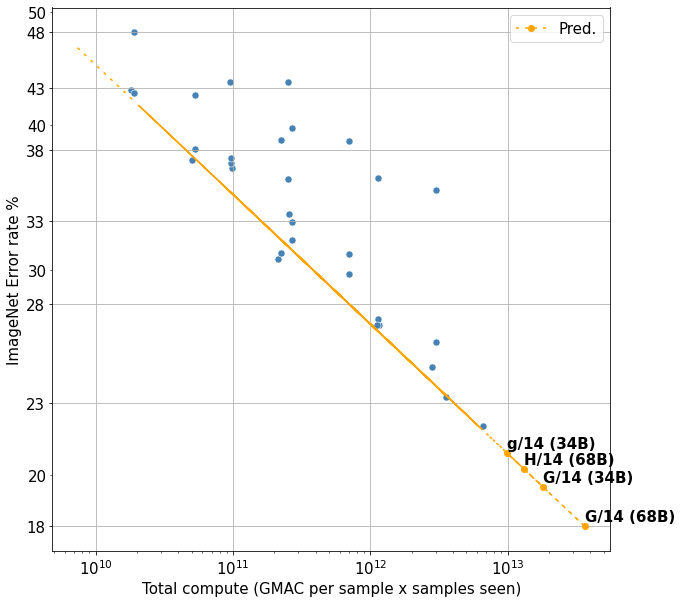

Predictions based on log-log error model:
B-32 1B 54.78 actual:
B-32 3B 58.03 actual:57.013195753097534
B-32 13B 63.12 actual:61.89923882484436
B-32 34B 65.84 actual:65.0539755821228
B-32 68B 67.67 actual:
B-16 1B 58.31 actual:
B-16 3B 61.31 actual:61.08356714248657
B-16 13B 66.00 actual:66.10955595970154
B-16 34B 68.51 actual:67.7289068698883
B-16 68B 70.20 actual:
L-14 1B 62.84 actual:
L-14 3B 65.52 actual:66.20551943778992
L-14 13B 69.70 actual:69.1563367843628
L-14 34B 71.94 actual:71.07957005500793
L-14 68B 73.44 actual:
H-14 1B 65.07 actual:
H-14 3B 67.58 actual:
H-14 13B 71.52 actual:
H-14 34B 73.62 actual:73.4306275844574
H-14 68B 75.03 actual:
g-14 1B 66.22 actual:
g-14 3B 68.65 actual:
g-14 13B 72.45 actual:72.39903807640076
g-14 34B 74.48 actual:
g-14 68B 75.85 actual:
G-14 1B 67.81 actual:
G-14 3B 70.12 actual:
G-14 13B 73.75 actual:
G-14 34B 75.68 actual:
G-14 68B 76.99 actual:


<Figure size 432x288 with 0 Axes>

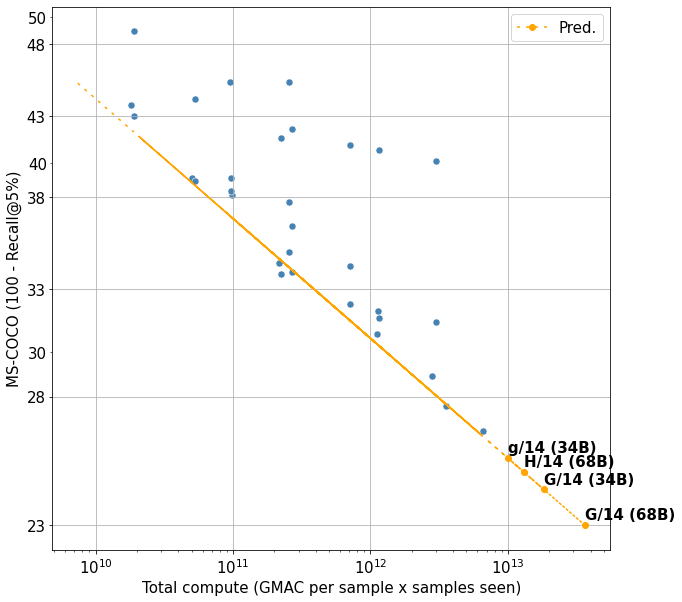

In [78]:
meta = pd.read_csv("arch_info.csv").set_index("model")
_1b = 1e9
_3b = 80000415 * 32
_13b = 407332084 * 32
_34b = 407332084 * 84
_68b = _34b * 2
samples_seen = [
    _1b,
    _3b, 
    _13b, 
    _34b, 
    _68b, 
]
samples_seen_names = ["1B", "3B", "13B", "34B", "68B"]
archs = ["ViT-B-32", "ViT-B-16", "ViT-L-14", "ViT-H-14", "ViT-g-14", "ViT-G-14",]
for target in ("imagenet1k", "mscoco_captions"):
    d = df[df.downstream_dataset==target]
    d = d[d.arch.isin(archs)]
    d = d.sort_values(by='gmacs_total')
    d = d[d.upstream_dataset != "CLIP-WIT"]
    X = np.log10(d.gmacs_total)
    Y = np.log10(d["err1"])
    fig = plt.figure()
    line_fit = binned_line_fit(X, Y, nbins=5)
    print("Predictions based on log-log error model:")
    x_pred = []
    y_pred = []
    pred_name = []
    for arch in archs:
        for seen in samples_seen:
            gmacs_per_sample = float(meta.loc[arch].gmacs)
            gmacs_total = seen * gmacs_per_sample
            seen_pretty = samples_seen_names[np.abs(np.array(samples_seen) - seen).argmin()]
            actual = d[(d.arch==arch)&(d.samples_seen_pretty==seen_pretty)]["err1"].values
            x_pred.append(gmacs_total)
            y_pred.append(pred(gmacs_total, line_fit))
            pred_name.append(f"{arch.replace('ViT-', '').replace('-','/')} ({seen_pretty})")
            print(f"{arch.replace('ViT-','')} {seen_pretty} {(1-pred(gmacs_total, line_fit))*100:.2f} actual:{100*(1-actual.min()) if len(actual) else ''}")
    x_pred = np.array(x_pred)
    y_pred = np.array(y_pred)
    fig, ax = plt.subplots(figsize=(10,10), constrained_layout=False)
    d["styles"] = d.upstream_dataset.apply(lambda f:upstream_dataset_styles[f])
    d = d.sort_values(by=["Dataset source", "data_scale"])
    df_pred = pd.DataFrame({"x": x_pred, "y": (np.array(y_pred))*100, "label": pred_name })
    OUT_LEFT = [
        "B/32 (1B)",
        "B/16 (1B)",
        "L/14 (1B)",
    ]
    OUT_RIGHT = [
        "g/14 (34B)",
        "H/14 (68B)",
        "G/14 (34B)",
        "G/14 (68B)",
    ]
    df_pred_in = df_pred[~df_pred.label.isin(OUT_RIGHT)]
    df_pred_out = df_pred[df_pred.label.isin(OUT_RIGHT)]
    df_pred_out_left = df_pred[df_pred.label.isin(OUT_LEFT)]
    sns.scatterplot(
        data=d.sort_values(by="data_scale"),
        x='gmacs_total',
        y='err1%',
        ax=ax,
        s=50,
        color='steelblue',
    )
    m_right = (df_pred.x > d.gmacs_total.max())
    m_left = (df_pred.x <= d.gmacs_total.nsmallest(2).iloc[1])
    m = m_left | m_right
    ax.plot(df_pred.x[~m], df_pred.y[~m], color='orange')
    ax.plot(df_pred.x[m_right], df_pred.y[m_right], color='orange', linestyle=(0,  (2,4)))
    ax.plot(df_pred_out.x, df_pred_out.y, color='orange', marker='o',linestyle=(0,  (2,4)), label="Pred.")
    ax.plot(df_pred.x[m_left], df_pred.y[m_left], color='orange', linestyle=(0,  (2,4)))
    for _, row in df_pred_out.iterrows():
        plt.text(row.x, row.y+0.2, row.label, size='medium', color='black', weight='semibold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.set_xlabel("Total compute (GMAC per sample x samples seen)")
    ax.set_ylabel(f"{target_pretty[target]} {metric_pretty[default_err_metric[target]+'%']}")
    minv = df_pred.y.min()-0.5
    maxv = df_pred.y.max()
    unit = 5
    minv = int(unit * (minv // unit + 1))
    maxv = int(unit * (maxv // unit + 1))
    minv = (df_pred.y.min())
    ax.grid(True,)
    ext = df_pred_out.y.values.tolist()
    ax.set_yticks( list(np.arange(minv, maxv, unit))  )
    ax.legend().set_visible(True)
    plt.savefig(f"prediction_plot_{target}.pdf")
    plt.show()